# <center>Trabajo Práctico N°2</center>

## <center>Kung Fu Pandas</center>

### <center>XGBoost</center>



# Librerias y Dataset

In [ ]:
import pandas as pd
import numpy as np

import sklearn as sk
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from six import StringIO
import pydotplus
from IPython.display import Image

from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import make_pipeline
import xgboost as xgb

In [ ]:
#Cargo el dataset
from google.colab import drive
drive.mount('/content/drive')

review = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/TP2/train.csv')
review_t = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/TP2/test.csv')
review_orig = review_t.copy()

review.head(10)

Mounted at /content/drive


,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
5,5,Probablemente mi película favorita de todos lo...,positivo
6,6,Seguro que me gustaría ver una resurrección de...,positivo
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo
8,8,Alentados por los comentarios positivos sobre ...,negativo
9,9,"Si te gusta la risa original desgarradora, te ...",positivo


### Preprocesamiento de Datos

In [ ]:
review['sentimiento'] = review['sentimiento'].map({'positivo':1,'negativo':0},na_action=None)
review.drop('ID', axis='columns', inplace=True)
review_t.drop('ID', axis='columns', inplace=True)

def metricas(y_pred,y_test):
  print(classification_report(y_test,y_pred))
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')



In [ ]:
target='sentimiento'
review_split=review.drop([target], axis='columns', inplace=False)
sentimientos = review[target].copy()
review_split.head()

,review_es
0,Uno de los otros críticos ha mencionado que de...
1,Una pequeña pequeña producción.La técnica de f...
2,Pensé que esta era una manera maravillosa de p...
3,"Básicamente, hay una familia donde un niño peq..."
4,"El ""amor en el tiempo"" de Petter Mattei es una..."


# Creación del modelo

**RandomizedSearchCV**

[22:59:47] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[23:00:05] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[23:00:25] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[23:00:44] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[23:01:04] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[23:01:09] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[23:01:15] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not

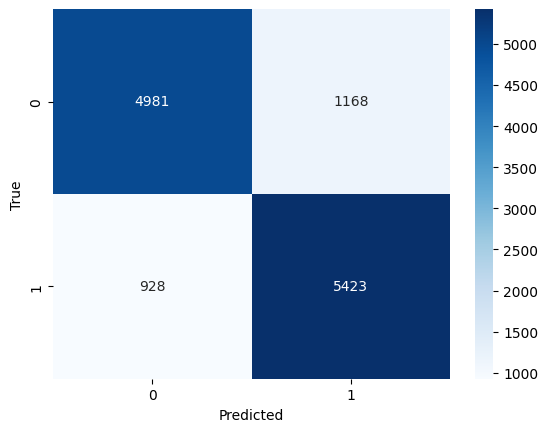

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(review_split, sentimientos, test_size = 0.25, random_state = 5)


n = 10
params_grid = {'objective': ['binary:logistic'], 'eval_metric': ['logloss'],
               'learning_rate': np.linspace(0.01, 0.1, n),
               'max_depth': list(range(1, 6)),
               'subsample': np.linspace(0.5, 1.0, n),
               'colsample_bytree': np.linspace(0.5, 1.0, n),
               'gamma': np.linspace(0, 0.5, n)}

params_grid = {'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


scorer_fn = make_scorer(f1_score)

model1 = make_pipeline(CountVectorizer(), RandomizedSearchCV(estimator=xgb.XGBClassifier(random_state=0, n_estimators=100),
                                                             param_distributions=params_grid, scoring=scorer_fn,
                                                             cv=4, n_iter=n))

model1.fit(X_train['review_es'], y_train)

best_xgb_1 = model1.named_steps['randomizedsearchcv'].best_estimator_
predicted_categories_1 = model1.predict(X_test['review_es'])

metricas(predicted_categories_1, y_test)


In [ ]:
y_predic = model1.predict(review_t['review_es'])
y_predic_cat = np.where(y_predic>0.5,1,0)

In [ ]:
review_orig['sentimiento'] = y_predic
review_orig['sentimiento'] = review_orig['sentimiento'].map({1:'positivo',0:'negativo'},na_action=None)
review_orig.head()

,ID,review_es,sentimiento
0,60000,La mayor virtud de esta película es su existen...,negativo
1,60001,"No soy un experto cinéfilo, pero pocas veces m...",negativo
2,60002,Si no eres un incondicional del humor estilo T...,negativo
3,60003,"No sé qué está pasando, si la gente se deja ll...",negativo
4,60004,"Pero cuando amanece,y me quedo solo,siento en ...",negativo


In [ ]:
entregable = pd.DataFrame({'ID': review_orig['ID'], 'sentimiento':review_orig['sentimiento']})

entregable.head()

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo


In [ ]:
entregable.to_csv('xgboost.csv', index=False)

**GridSearchCV**

Se intenta mejorar los hiperparámetros mediante GridSearch pero no se pudo llevar a cabo debido al tiempo que demora la ejecución.

# Exporto modelo

In [ ]:
pickle.dump(model1, open("XGB_model", "wb"))